# Introduction
This Jupiter Notebook implements a machine learning algorithm to detect sign language with a sensor glove. The glove uses 6 flex sensors, one for each finger and one for the wrist. Additionally, an IMU is placed on the top of the wrist.
For the sign language signal processing and classification, we utilize the capabilities of a **Convolutional Neural Network (CNN) Autoencoder**.

Our primary objective is to construct a robust Autoencoder model tailored for the task of detecting sign language.

## Dataset Overview

  The data is generated with the sensor glove connected to an ESP32 and an Arduino code implementing a fixed data collection for a specified time of 1.5 seconds for each sign. The data is collected in following order: XAcc,YAcc,ZAcc,XGyro,YGyro,ZGyro,Thumb,Index,Middle,Ring,Pinkie,Wrist, Wheras the finger and wrist data has to be calibrated before data generation.
  The dataset is sampled at 100Hz, providing high-resolution data for in-depth analysis.

 The generated sign lanuge data set consists of five signs of Austrian Sign Language (österreichische Gebärdensprache): Bitte, Danke, Ich, Hallo und Baba. We categorized them into five classes with the same name.

  We used a randomized order to collect data to ensure a variable and not prejudiced data generation. Therefore we generated a variable order of 10 signs out of the signs Bitte, Danke, Ich, Hallo, Tschüss.
  The Arduino code generated the raw data where every 1.5 seconds is an empty line in between each singn. Then we copied the raw data out of the serial monitor in a text file.
  
  Afterwards, we separated each sign into corresponding text files named using the format SignName_Initial_Number (for example: hallo_m_1 for the first file with "Hallo" from Martina). To ensure the same data length for each file, we decided to cut the files at 37 lines. If a file had 38 lines, the last line was deleted to maintain uniformity of the data.

> Some essential details about the Database:
>
> - **Number of Samples:** X
> - **Number of Categories:** 5
> - **Sampling Frequency:** 100Hz

import relevant librarys

In [ ]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")
import tensorflow as tf
from tensorflow import data
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mae
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report,ConfusionMatrixDisplay
import os
import glob
import random


In [ ]:
# generate accesss to the drive (=data) there are all the labelled csv. files stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change to the directory where your text files are located
os.chdir('/content/drive/MyDrive/Colab Notebooks/MCI /Sign Glove/Data/Data seperated all together')

In [ ]:
# List files in the directory to verify
file_list = os.listdir()
print(file_list)

# Display the class names (folders)
for file_name in file_list:
    if file_name.endswith('.txt'):  # Check if it is a text file
        with open(file_name, 'r') as file:
            content = file.read()

['Baba', 'Bitte', 'Danke', 'Hallo', 'Ich']


Read all the text files, get access to text files in subfolders

In [ ]:

# Function to read all text files in nested directories
def read_text_files_in_nested_directories(base_path):
    data = {}
    # Iterate over each subdirectory in the base path
    for subdir in os.listdir(base_path):
        subdir_path = os.path.join(base_path, subdir)
        if os.path.isdir(subdir_path):
            # Initialize a list to store contents of files in the subdirectory
            data[subdir] = []
            # Get all text files in the current subdirectory
            text_files = glob.glob(os.path.join(subdir_path, '*.txt'))
            for text_file in text_files:
                with open(text_file, 'r') as file:
                    content = file.read()
                    data[subdir].append(content)
    return data

# Base path to your main folder containing subfolders
base_path = '/content/drive/MyDrive/Colab Notebooks/MCI /Sign Glove/Data/Data seperated all together'
data = read_text_files_in_nested_directories(base_path)


# display shape of data
to see how much data is in each folder and if the line number of 37 is correct

In [ ]:
#function to count text files in folder
def count_text_files_in_folder(folder_path):
    file_count = sum(1 for file in os.listdir(folder_path) if file.endswith('.txt'))
    return file_count

# function to count lines in text files
def count_lines_in_text_files(folder_path):
    file_line_counts = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                lines = file.readlines()
                line_count = len(lines)
                file_line_counts[filename] = line_count
    return file_line_counts

# names of subfolders
subfolders = ["Bitte", "Baba", "Danke", "Hallo", "Ich"]

# Zähle die Anzahl der Textdateien und die Anzahl der Zeilen in jedem Unterordner
for folder_name in subfolders:
    folder_path = os.path.join(base_path, folder_name)
    file_count = count_text_files_in_folder(folder_path)
    line_count = count_lines_in_text_files(folder_path)
    print(f"Folder '{folder_name}': Numer of text files: {file_count}, number of lines: {line_count}")

Folder 'Bitte': Numer of text files: 60, number of lines: {'bitte_m_1.txt': 37, 'bitte_e_8.txt': 37, 'bitte_j_14.txt': 37, 'bitte_j_3.txt': 37, 'bitte_m_19.txt': 37, 'bitte_m_6.txt': 37, 'bitte_j_19.txt': 37, 'bitte_m_12.txt': 37, 'bitte_j_4.txt': 37, 'bitte_m_9.txt': 37, 'bitte_m_13.txt': 37, 'bitte_m_8.txt': 37, 'bitte_m_15.txt': 37, 'bitte_m_11.txt': 37, 'bitte_j_7.txt': 37, 'bitte_j_8.txt': 37, 'bitte_e_2.txt': 37, 'bitte_m_14.txt': 37, 'bitte_j_2.txt': 37, 'bitte_m_5.txt': 37, 'bitte_j_6.txt': 37, 'bitte_e_1.txt': 37, 'bitte_m_22.txt': 37, 'bitte_j_9.txt': 37, 'bitte_j_12.txt': 37, 'bitte_m_23.txt': 37, 'bitte_m_10.txt': 37, 'bitte_e_4.txt': 37, 'bitte_j_11.txt': 37, 'bitte_m_16.txt': 37, 'bitte_j_18.txt': 37, 'bitte_m_21.txt': 37, 'bitte_j_23.txt': 37, 'bitte_m_24.txt': 37, 'bitte_e_11.txt': 37, 'bitte_j_13.txt': 37, 'bitte_j_5.txt': 37, 'bitte_m_4.txt': 37, 'bitte_e_9.txt': 37, 'bitte_e_10.txt': 37, 'bitte_e_3.txt': 37, 'bitte_m_18.txt': 37, 'bitte_j_10.txt': 37, 'bitte_j_20.txt

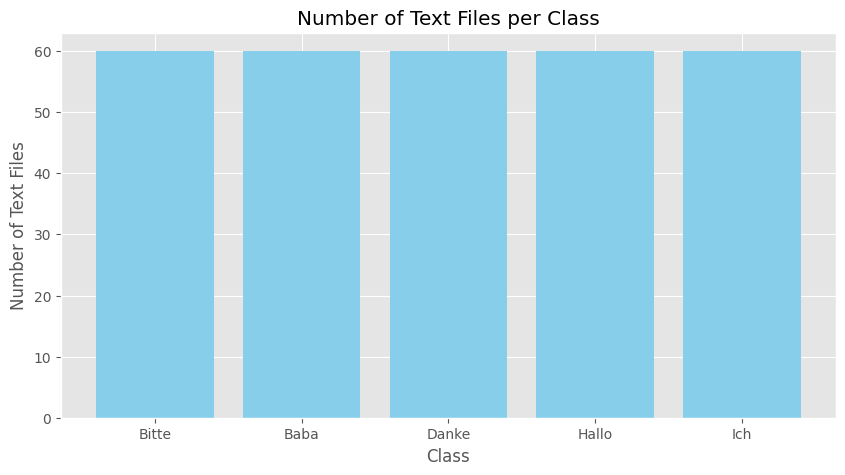

In [ ]:
# Plot amount of text data
plt.figure(figsize=(10, 5))
plt.bar(subfolders, file_count, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Text Files')
plt.title('Number of Text Files per Class')
plt.show()

The code below generates a visual comparison between two randomly selected datasets for a sign. This side-by-side plot enables a direct visual assessment of signal patterns between the two signs.

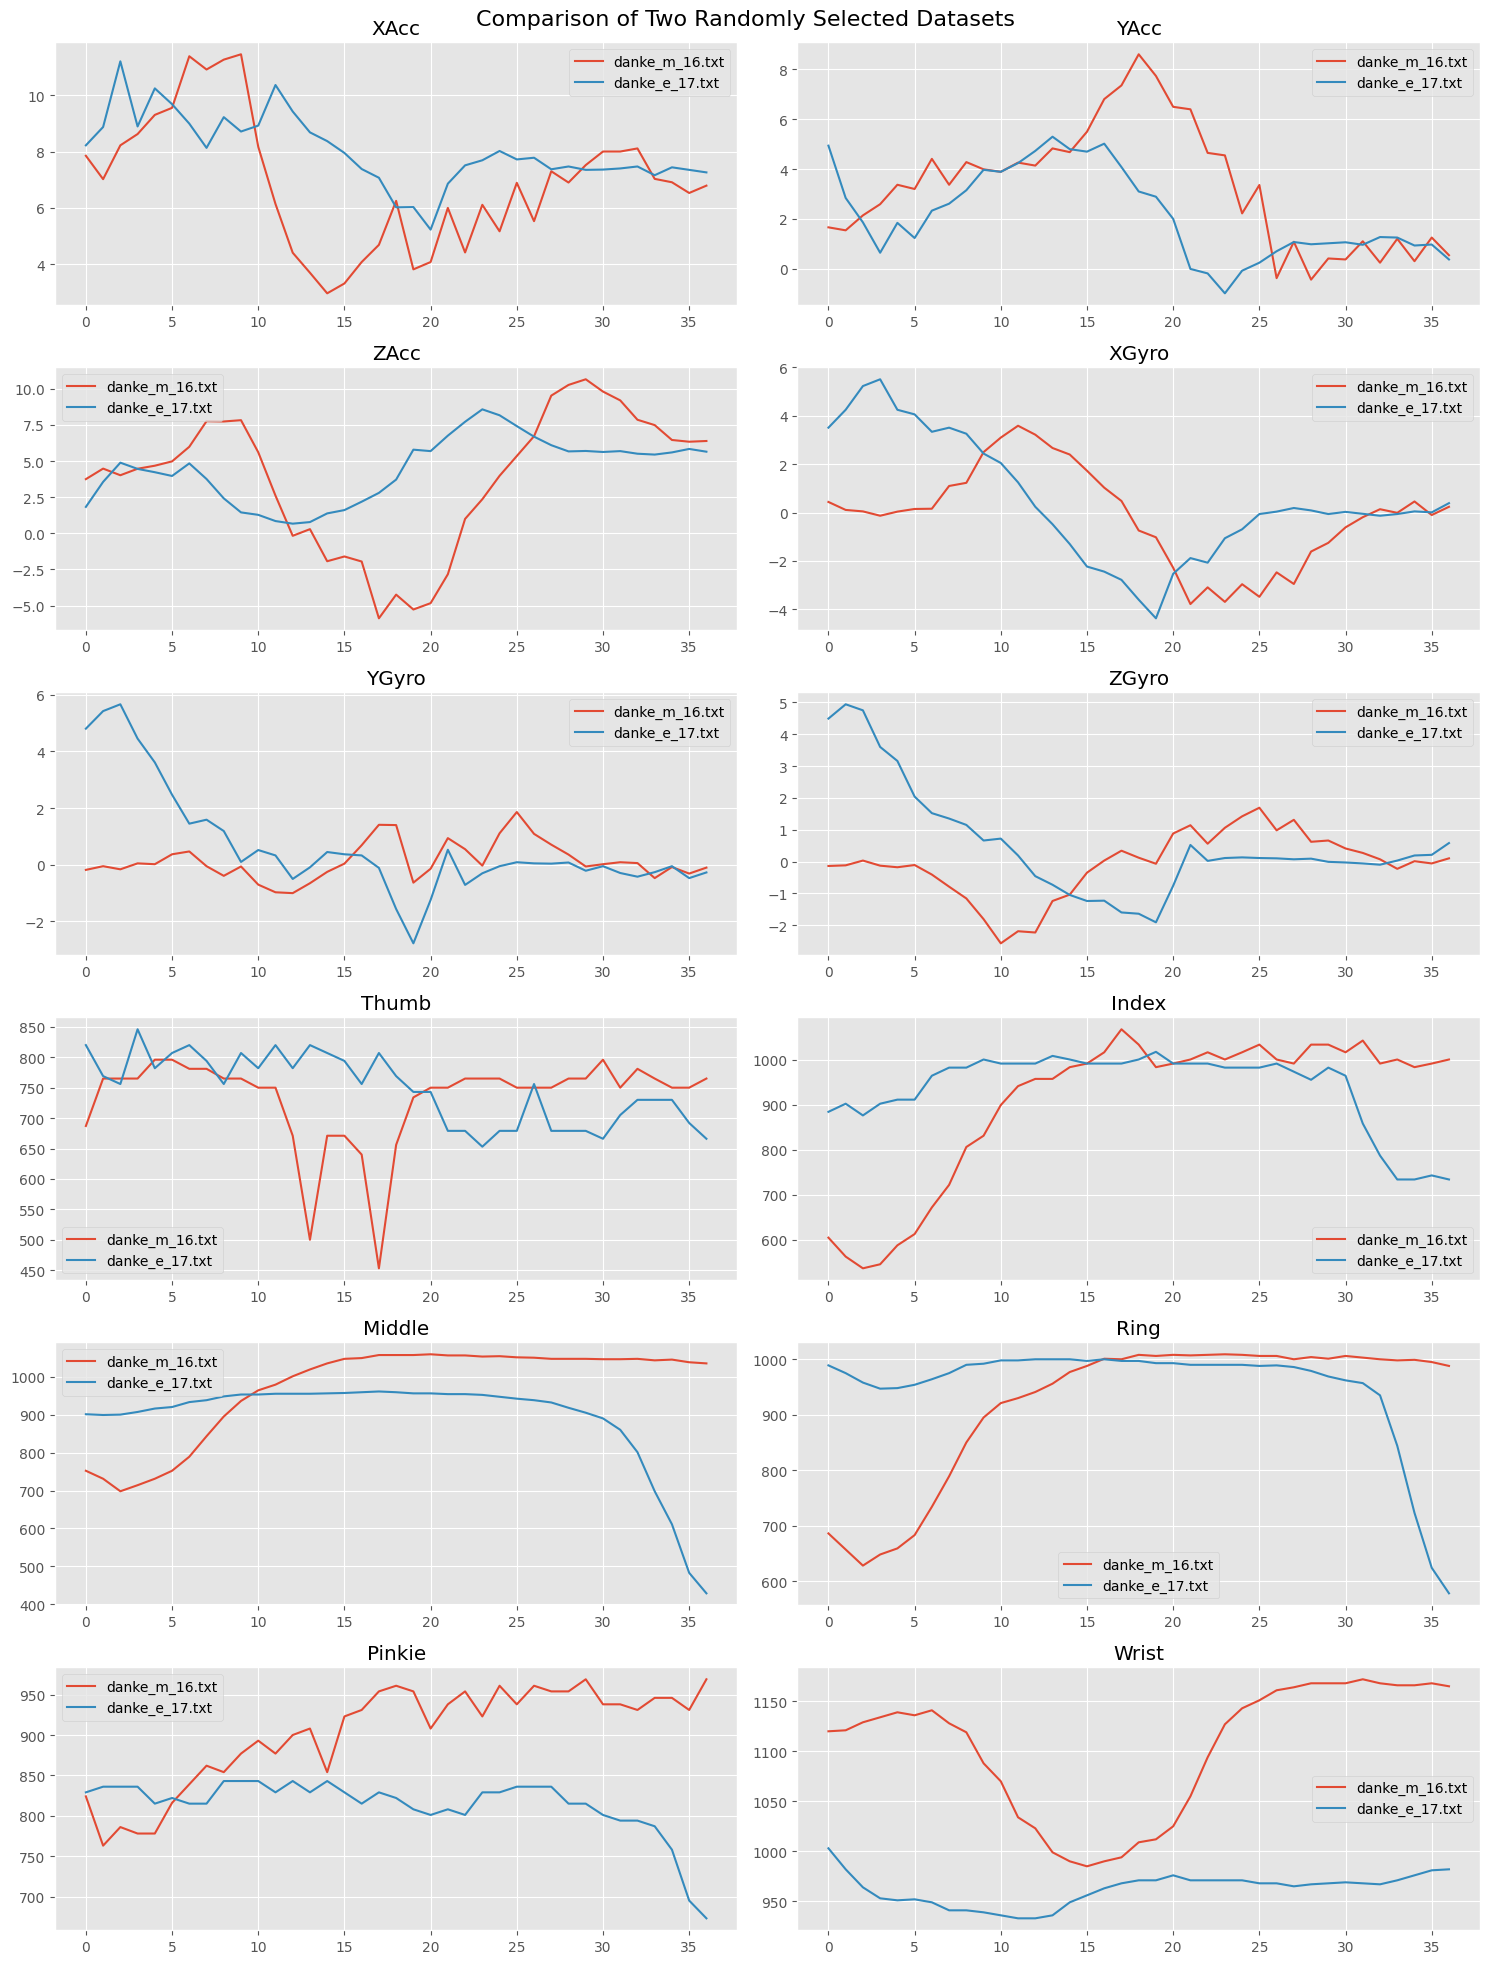

In [ ]:
# Function to load data from a text file
def load_data(file_path):
    data = pd.read_csv(file_path, header=None)
    data.columns = ['XAcc', 'YAcc', 'ZAcc', 'XGyro', 'YGyro', 'ZGyro', 'Thumb', 'Index', 'Middle', 'Ring', 'Pinkie', 'Wrist']
    return data

# Function to plot data
def plot_data(data1, data2, label1, label2):
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 20))
    fig.suptitle('Comparison of Two Randomly Selected Datasets', fontsize=16)

    for i, column in enumerate(data1.columns):
        ax = axes[i//2, i%2]
        ax.plot(data1[column], label=label1)
        ax.plot(data2[column], label=label2)
        ax.set_title(column)
        ax.legend()

    plt.tight_layout()
    plt.show()

# Read all text files in nested directories
data_dict = {}
for subdir in os.listdir(base_path):
    subdir_path = os.path.join(base_path, subdir)
    if os.path.isdir(subdir_path):
        text_files = glob.glob(os.path.join(subdir_path, '*.txt'))
        data_dict[subdir] = text_files

# Randomly select two files
random_sign = random.choice(list(data_dict.keys()))
file1, file2 = random.sample(data_dict[random_sign], 2)

# Load the datasets
data1 = load_data(file1)
data2 = load_data(file2)

# Plot the data
plot_data(data1, data2, os.path.basename(file1), os.path.basename(file2))

make one total dataframe and assign labels and classnames
Ensure that each data point has an associated label or class name.


In [ ]:
# load data from text files and label them and assign classnames
def load_and_label_data(folder_path, class_label, class_name):
    data_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, sep=',', header=None)  # data is seperated trough , and without header
            df['Label'] = class_label
            df['ClassName'] = class_name
            data_list.append(df)
    return data_list

bitte_path = os.path.join(base_path, "Bitte")
hallo_path = os.path.join(base_path, "Hallo")
baba_path = os.path.join(base_path, "Baba")
danke_path = os.path.join(base_path, "Danke")
ich_path = os.path.join(base_path, "Ich")

bitte_data = load_and_label_data(bitte_path, class_label=0, class_name="Bitte")
hallo_data = load_and_label_data(hallo_path, class_label=1, class_name="Hallo")
baba_data = load_and_label_data(baba_path, class_label=2, class_name="Baba")
danke_data = load_and_label_data(danke_path, class_label=3, class_name="Danke")
ich_data = load_and_label_data(ich_path, class_label=4, class_name="Ich")

# Combine all data into one list
combined_data = bitte_data + hallo_data + baba_data + danke_data + ich_data

# Convert the list of DataFrames to a single NumPy array
combined_data_np = np.array([df.iloc[:, :-2].values for df in combined_data])
# Convert the list of DataFrames to a single NumPy array
combined_data_with_labels_np = np.array([df.iloc[:, :-1].values for df in combined_data])
# Convert the list of DataFrames to a single NumPy array
combined_data_with_labels_and_classes_np = np.array([df.values for df in combined_data])

print("Shape of the combined data array:", combined_data_np.shape)
print("Shape of the combined data array with labels and classification:", combined_data_with_labels_np.shape)
print("Shape of the combined data array with labels and classification:", combined_data_with_labels_and_classes_np.shape)

# Adjust Pandas display options to show all columns beneath each other
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 2000)

# Display random samples from combined_data (list of DataFrames)
random_data_samples = random.sample(combined_data, 3)
for i, df in enumerate(random_data_samples):
    print(f"DataFrame {i+1}:")
    print(df.head())
    print(df.shape)

# Display random samples from combined_data_with_labels_np (NumPy array)
random_data_samples_np = random.sample(list(combined_data_with_labels_np), 3)
for i, df_np in enumerate(random_data_samples_np):
    df = pd.DataFrame(df_np)
    print(f"NumPy Array to DataFrame {i+1}:")
    print(df.head())
    print(df.shape)

# Display random samples from combined_data_with_labels_and_classes_np (NumPy array)
random_data_samples_np = random.sample(list(combined_data_with_labels_and_classes_np), 3)
for i, df_np in enumerate(random_data_samples_np):
    df = pd.DataFrame(df_np)
    print(f"NumPy Array to DataFrame {i+1}:")
    print(df.head())
    print(df.shape)


Shape of the combined data array: (300, 37, 12)
Shape of the combined data array with labels and classification: (300, 37, 13)
Shape of the combined data array with labels and classification: (300, 37, 14)
DataFrame 1:
       0     1     2     3     4     5    6    7    8    9   10    11  Label ClassName
0  10.32  3.54  2.50  1.01  3.22  3.24  781  537  844  754  816  1116      1     Hallo
1  10.32  4.21  3.05  0.69  1.91  2.83  796  588  821  730  755  1112      1     Hallo
2  12.00  2.31  3.21  0.64  0.78  1.97  750  630  817  721  778  1114      1     Hallo
3  12.19  3.72  3.43  0.00 -0.08  0.86  750  621  814  706  740  1121      1     Hallo
4  11.99  2.88  3.19  0.54 -0.18  0.14  750  621  812  703  717  1125      1     Hallo
(37, 14)
DataFrame 2:
       0     1     2     3     4     5    6    7    8    9   10    11  Label ClassName
0   3.51  9.38  1.58  1.40  2.02  3.29  692  787  760  789  723  1054      4       Ich
1   4.99  6.80  4.36  3.93  4.29  6.35  641  849  762  696  659

**explanation of the lines above**
The total dataframe consists 300 signs recorded, which makes 60 datasets per sign.
Each text file consists of 37 timesteps.
Each row (timestep) has 14 columns containing the following data:
12 measurements (XAcc,YAcc,ZAcc,XGyro,YGyro,ZGyro,Thumb,Index,Middle,Ring,Pinkie,Wrist), 1 label column (Label),1 class name column (ClassName), which relusts in a matrix: (37,14).

## Splitting the data to training and testing set

In [ ]:
# Define X by excluding the last two columns (Label and ClassName)
X = combined_data_np

# Define Y by keeping only the last two columns (Label and ClassName)
Y = combined_data_with_labels_np[:, :, -1:]

# Perform train-test split with a ratio of 90% for training and 10% for testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# Display the shapes of train and test sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Train set shape: (270, 37, 12) (270, 37, 1)
Test set shape: (30, 37, 12) (30, 37, 1)


plot shapes of train and test set to check if it is correct

In [ ]:
# Print the shape of X_train, X_test, y_train, y_test
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (270, 37, 12)
Shape of X_test: (30, 37, 12)
Shape of y_train: (270, 37, 1)
Shape of y_test: (30, 37, 1)


Redefine Output to one hot encoded outputs

In [ ]:
ohe_y_train=np.zeros((len(y_train[:,0,0]),5))

for i in range(0,len(y_train[:,0,0])):
  ohe_y_train[i,int(y_train[i,0,0])]=1

ohe_y_test=np.zeros((len(y_train[:,0,0]),5))

for i in range(0,len(y_test[:,0,0])):
  ohe_y_test[i,int(y_test[i,0,0])]=1



In [ ]:
# Print the shape of X_train, X_test, y_train, y_test
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", ohe_y_train.shape)
print("Shape of y_test:", ohe_y_test.shape)

Shape of X_train: (270, 37, 12)
Shape of X_test: (30, 37, 12)
Shape of y_train: (270, 5)
Shape of y_test: (270, 5)


# Building Model

Reset everything so that by running the code again it is not using the pretrained data.


In [ ]:
# Function to reset random seeds
def reset_everything():
    RANDOM_SEED = 42
    np.random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)

# Assuming you already have your data split and preprocessed
# X_train_scaled, X_test_scaled, y_train, y_test are already defined

# Call the reset_everything function before defining the model
reset_everything()

In [ ]:
tf.keras.utils.set_random_seed(1024)

In [ ]:
class ourownmodel(tf.keras.Model):
    def __init__(self, input_shape):
        super(ourownmodel, self).__init__()

        # Encoder part
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=input_shape),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(5, activation='sigmoid')  # Keep the activation function suitable for your output
        ])

    def call(self, X):
        encoded = self.encoder(X)
        return encoded

In [ ]:
# Adjust input_shape to include the channel dimension
input_shape = (37, 12, 1)  # Assuming single-channel data (e.g., grayscale)

# Create an instance of the autoencoder for 3D data
ourownmodelinstance = ourownmodel(input_shape)

# Compile the model
ourownmodelinstance.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy())

# Ensure X_train is reshaped to include the channel dimension
X_train_reshaped = X_train.reshape(-1, 37, 12, 1)
ohe_y_train = ohe_y_train.reshape(-1, 5)  # Adjust the shape based on your target

# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)
history = ourownmodelinstance.fit(X_train_reshaped, ohe_y_train, epochs=50, batch_size=1, validation_split=0.1, callbacks=[early_stopping])

# Summary of the model
ourownmodelinstance.encoder.summary()

Epoch 1/50
243/243 [==============================] - 5s 6ms/step - loss: 11.3800 - val_loss: 2.5502
Epoch 2/50
243/243 [==============================] - 1s 5ms/step - loss: 0.7949 - val_loss: 0.6229
Epoch 3/50
243/243 [==============================] - 1s 5ms/step - loss: 0.4130 - val_loss: 0.4684
Epoch 4/50
243/243 [==============================] - 1s 5ms/step - loss: 0.1569 - val_loss: 0.1054
Epoch 5/50
243/243 [==============================] - 1s 6ms/step - loss: 0.3825 - val_loss: 0.2753
Epoch 6/50
243/243 [==============================] - 2s 7ms/step - loss: 0.1135 - val_loss: 0.1218
Epoch 7/50
243/243 [==============================] - 2s 8ms/step - loss: 0.0801 - val_loss: 0.0322
Epoch 8/50
243/243 [==============================] - 1s 5ms/step - loss: 0.0507 - val_loss: 0.0786
Epoch 9/50
243/243 [==============================] - 1s 5ms/step - loss: 0.0149 - val_loss: 0.1673
Epoch 10/50
243/243 [==============================] - 1s 5ms/step - loss: 0.0110 - val_loss: 0.174

display training hisory

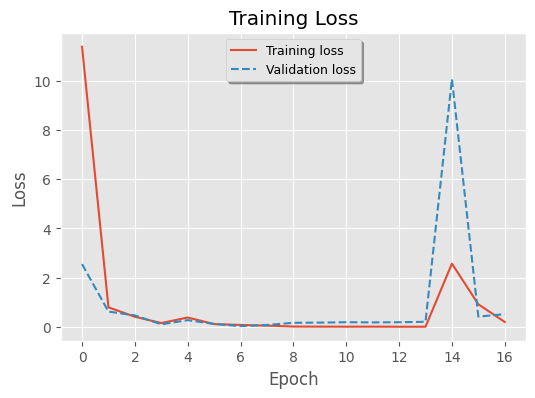

In [ ]:
# Display training history
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

#Evaluation of network

In [ ]:
predictions=ourownmodelinstance.call(X_train)
print(ohe_y_train)
#print(predictions)
#print(np.max(predictions,axis=1))
#classified_predictions=predictions==np.max(predictions)

res=np.empty_like(predictions.numpy())

#as we have 3 cases where two classes have the same value, we need to decide for one class only
for i in range(0,len(predictions[:,0])):
  res[i,:]=(predictions[i,:]==np.max(predictions[i,:])).numpy()+0
  if np.sum(res[i,:])>1:
    count=0
    for j in range(0,len(res[i,:])):
      if res[i,j] == 1:
        count=count+1
        if count>1:
          res[i,j]=0
print(res)

[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]


In [ ]:
#check if there ase double assigned classes
print(np.sum(res,axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


#Confusion matrix

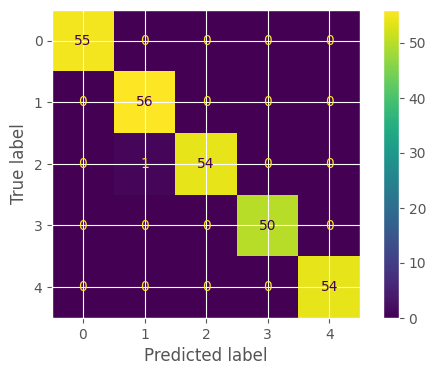

In [ ]:
cm=confusion_matrix(np.argwhere(ohe_y_train)[:,1],np.argwhere(res)[:,1])
ConfusionMatrixDisplay(cm).plot()
#classification_report(np.argwhere(ohe_y_train)[:,1],np.argwhere(res)[:,1])

#Adapt to our case

In [ ]:
print("Training", evaluate_model(model, X_train))
print("Testing", evaluate_model(model, X_test))

Training Accuracy: 84.79%
Testing Accuracy: 84.84%
Anomaly Accuracy: 46.90%


## Model Evaluation Metrics

The following evaluation metrics provide a comprehensive assessment of the performance of our model:

- **Accuracy (76.93%)**: Accuracy measures the proportion of correct predictions out of all predictions made by the model, indicating an exceptionally high overall classification correctness.

- **Precision (55.23%)**: Precision is the percentage of true positive predictions relative to all positive predictions made by the model, signifying the model's precision in correctly identifying positive instances.

- **Recall (89.81%)**: Recall, also known as sensitivity, represents the model's ability to accurately identify positive instances out of all actual positive instances, demonstrating a strong capability to capture true positives.

- **F1 Score (65.40%)**: The F1 score is a composite metric that balances precision and recall, providing an overall measure of model performance.

In [ ]:
ytrue, ypred = prepare_labels(model, X_train, X_test, anomaly, threshold=threshold)
print(classification_report(ytrue, ypred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      Normal       0.94      0.76      0.84     10505
     Anomaly       0.58      0.88      0.70      4045

    accuracy                           0.79     14550
   macro avg       0.76      0.82      0.77     14550
weighted avg       0.84      0.79      0.80     14550



Thank you for taking the time to explore my notebook and delve into the world of data science with me. Your interest and engagement are greatly appreciated, and I hope you found valuable insights and inspiration within these pages.